**AdaBoost композиция классификаторов** 

Евгений Борисов  <esborisov@sevsu.ru>

MachineLearning.ru : Алгоритм_AdaBoost   
http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_AdaBoost

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

(1024, 2)

(1024, 1)

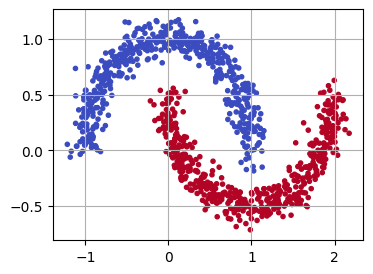

In [2]:
from sklearn.datasets import make_moons
X,target = make_moons(n_samples=1024, noise=.09)

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

target = (2*target-1).reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
# target

In [4]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

## базовая модель

decision stump (решающий пень) - решающее дерево единичной глубины 

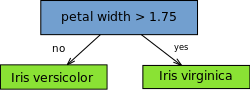

пороговый классификатор отказами

$$
a(x;s,t) = s\cdot sign \left( x - t \right) ; s \in \lbrace-1,+1 \rbrace
$$

In [6]:
class DecisionStumpClassifier:
    
    def __init__( self, n_feature=0, threshold=0., sig=+1, ):
        self._threshold = threshold # порог значения
        self._n_feature = n_feature # номер признака
        self._sig = sig # знак классификатора ( > или < )
            
    def score(self,x): 
        assert len(x)>0
        assert len(x.shape)==2
        return ( x[:,[self._n_feature]] - self._threshold )
    
    def predict(self,x): 
        return self._sig * np.sign( self.score(x) ).astype(np.int8)
    
    @property
    def threshold(self): return self._threshold

    @threshold.setter
    def threshold(self,value): self._threshold = value    

    @property
    def n_feature(self): return self._n_feature

    @n_feature.setter
    def n_feature(self,value): self._n_feature = value            
        
    @property
    def sig(self): return self._sig

    @sig.setter
    def sig(self,value): self._sig = value      

In [7]:
# DecisionStumpClassifier().predict(X_train)

## обучение базовой модели

In [8]:
class TrainDecisionStumpClassifier:
    
    def __init__(self,model,n_thresholds=16):
        assert n_thresholds>1
        self._model = model
        self._n_thresholds=n_thresholds

    def fit( self, X, target ):
        err = self._search_split(X,target) 
        return err, self._model
    
    # поиск оптимальной гиперплоскости ограниченным перебором
    def _search_split( self, X, target): # n_thresholds - количество порогов для перебора
        thresholds = self._get_thresholds(X)
        
        (n_feature_minus,threshold_minus),err_minus = self._search_split_sig(X,target,thresholds,sig=-1)
        (n_feature_plus, threshold_plus), err_plus  = self._search_split_sig(X,target,thresholds,sig=+1)
        
        if err_minus < err_plus:
            self._model.threshold = threshold_minus
            self._model.n_feature = n_feature_minus   
            self._model.sig = -1     
            return err_minus
        
        self._model.threshold = threshold_plus
        self._model.n_feature = n_feature_plus  
        self._model.sig = +1     
        return err_plus
    
    def _search_split_sig(self,X,target,thresholds,sig):
        self._model.sig = sig
        # оценка классификатора для каждого признака и порога 
        errors = self._errors_matrix(X,target,thresholds)
        # индексы минимального значения в матрице ошибок
        n_threshold,n_feature = np.unravel_index(errors.argmin(),errors.shape)
        return (n_feature,thresholds[n_threshold,n_feature]),errors[n_threshold,n_feature]
        
    def _get_thresholds(self,X):
        # min и max для каждого признака
        xmm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
        # список порогов для каждого признака
        return np.linspace( start=xmm[:,0], stop=xmm[:,1], num=self._n_thresholds )[1:-1]
    
    def _errors_matrix(self,X,target,thresholds):
        n_features = thresholds.shape[1]
        n_thresholds = thresholds.shape[0]
        # оценка классификатора для каждого признака и порога 
        return np.array([ 
                [ 
                    self._criterium(
                            X,target,
                            n_feature=n_feature,
                            threshold=thresholds[n_threshold,n_feature],
                        ) 
                    for n_feature in range(n_features)  
                ]
                for n_threshold in range(n_thresholds) 
            ])
        
    def _criterium(self,x,target,n_feature,threshold):
        self._model.threshold = threshold
        self._model.n_feature = n_feature
        # суммарная ошибка для признака n_feature и порога threshold
        return self._errors(x,target).sum() 

    # ошибки классификатора
    def _errors(self,x,target):
        # ответ ошибочный и не отказ (!=0)
        return ( (self._model.predict(x)*target) < 0 ).astype(int) 


---

In [9]:
err,model = TrainDecisionStumpClassifier(model=DecisionStumpClassifier()).fit(X_train,target_train)
display( 1.-(err/len(target_train)) ) # accuracy
display(( model.n_feature, model.sig, model.threshold,) )

0.844

(1, -1, 0.212)

              precision    recall  f1-score   support

          -1       0.82      0.85      0.83       257
           1       0.84      0.81      0.83       255

    accuracy                           0.83       512
   macro avg       0.83      0.83      0.83       512
weighted avg       0.83      0.83      0.83       512



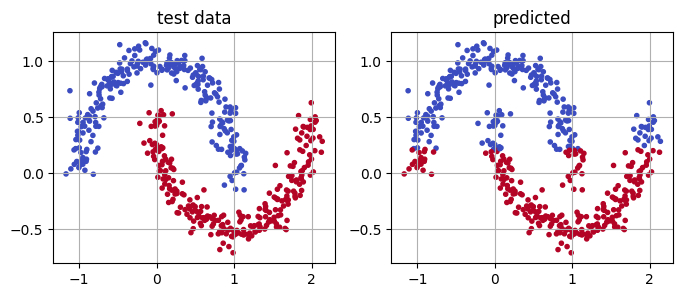

In [10]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## композиция моделей

взвешенное голосование 

$$
a(x) = sign \left( \sum_{i=1}^T w_i \cdot b_i(x) \right)
$$

In [11]:
class WeigtedVotingEnsembleClassifier:
    
    def __init__( self,weight=[],models=[]):
        assert len(weight)==len(models)
        self._weight = weight
        self._models = models
            
    def score(self,x):
        assert len(x)>0
        assert len(self._models)>0
        assert len(self._weight)==len(self._models)
        return np.hstack([ 
                w*b.predict(x) for w,b in zip(self._weight,self._models) 
            ]).sum(axis=-1,keepdims=True)
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)  
   
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    @property
    def models(self): return self._models

    @models.setter
    def models(self,value): self._base = value
     
    def append(self,model,weight):
        self._weight.append(weight)
        self._models.append(model)
        return self
    
    # def __del__(self): del self._models

In [12]:
# WeigtedVotingEnsembleClassifier(
#         models=[ DecisionStumpClassifier(),DecisionStumpClassifier() ],
#         weight=[.7,.3],
#     ).predict(X_train)

## обучение композиции

каждому учебному примеру присваиваем вес - вероятность ошибки на примере

In [13]:
# модификация метода обучения базовой модели
class WeigtedTrainDecisionStumpClassifier(TrainDecisionStumpClassifier):
    
    def __init__(self,model, n_thresholds=16 ):
        super().__init__(model, n_thresholds)
        self._xweight = 1. # веса примеров 
        
    def fit( self, X, xweight, target):
        self._xweight = xweight
        return super().fit(X,target)
    
    def _criterium(self,x,target,n_feature,threshold):
        self._model.threshold = threshold
        self._model.n_feature = n_feature
        # взвешенная суммарная ошибка    
        return ( self._errors(x,target)*self._xweight ).sum()

----

In [14]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

In [15]:
class TrainAdaBoost:
    
    def __init__(self,ensemble, base_train ):
        self._ensemble = ensemble
        self._base_train = base_train

    def fit(self,X,target,n_epoch=128,acc_min=.99):
        assert len(X)>1
        assert len(X)==len(target)
        assert len(X.shape)==2
        assert len(target.shape)==2
        assert target.shape[1]==1
        
        # начальные веса примеров, на старте  ошибки равновероятны для всех примеров
        xweight = np.ones(shape=target.shape)
        xweight = xweight/xweight.sum()

        # добавка для расчёта веса компоненты на случай отсутствия ошибок 
        # чтобы знаменатель не обращался в нуль
        d = 1./len(target) 
        
        acc_history = [0.]
        loss_history = [1.]
        
        for jj in range(n_epoch):
            _,model = self._base_train.fit(X,xweight,target)

            o = model.predict(X)

            p = ((o*target>0)*xweight).sum() # сумма весов правильных ответов
            n = ((o*target<0)*xweight).sum() # сумма весов ошибочных ответов

            # print(n,p)
            
            # базовый классификатор должен выдавать результат лучше чем случайный выбор 
            if( n > .5 ): break
                
            a = np.log((p+d)/(n+d)) # вычисляем вес классификатора
            
            # добавляем классификатор в композицию
            self._ensemble.append(deepcopy(model),a)
            
            # обновляем веса объектов
            xweight = xweight * np.exp( -a*target*o )
            xweight = xweight/xweight.sum()

            p = self._ensemble.predict(X)
            acc_history.append( accuracy_score( target, p) ) # значение погрешности композиции
            loss_history.append( self._loss(target,p) ) # значение погрешности композиции
            
            # проверяем достижение минимального порога погрешности модели
            if acc_history[-1] > acc_min: break
        
        return (acc_history,loss_history), self._ensemble
    
    # значение ф-ции потери для композиции классификаторов
    def _loss(self,target,predicted): 
        return np.exp( -target * predicted ).sum()/len(target)

In [16]:
# del model

In [17]:
model = WeigtedVotingEnsembleClassifier()
(acc_history,loss_history),model = TrainAdaBoost(
         ensemble=model,
         base_train=WeigtedTrainDecisionStumpClassifier(model=DecisionStumpClassifier() )
     ).fit(X_train,target_train)

In [18]:
display(len(model.models) )
# display(model.weight) 

13

In [19]:
# from IPython.display import Math 

# sig = {-1:'<',+1:'>'}
 
# display( Math(
#     ' + '.join([ 
#         f'{w:.3f} \cdot \left[ x_{b.n_feature} {sig[b.sig]} {b.threshold:.3f} \\right]' 
#         for w,b in zip( model.weight,model.models) 
#     ])
# )) 

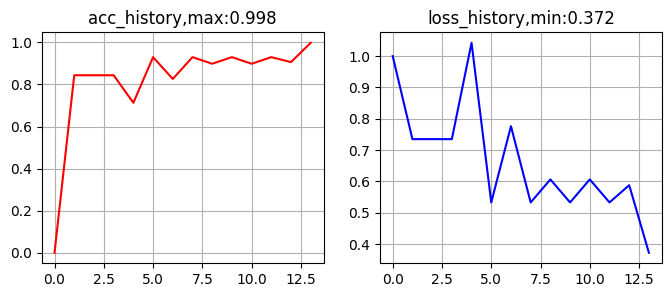

In [20]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3),)
ax[0].plot(acc_history,c='r')
ax[0].set_title(f'acc_history,max:{max(acc_history):.3f}')
ax[0].grid()
ax[1].plot(loss_history,c='b')
ax[1].set_title(f'loss_history,min:{min(loss_history):.3f}')
ax[1].grid()

# тестируем

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       257
           1       1.00      1.00      1.00       255

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



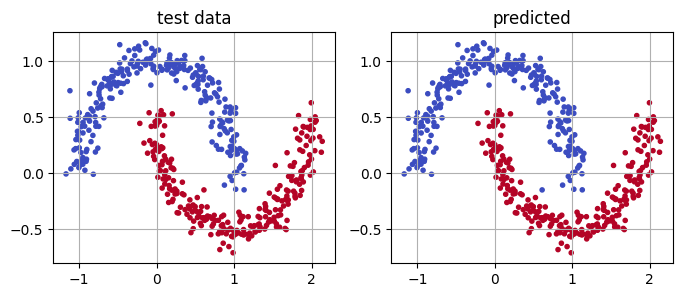

In [21]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## карта скоров

In [22]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [23]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(xy)
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

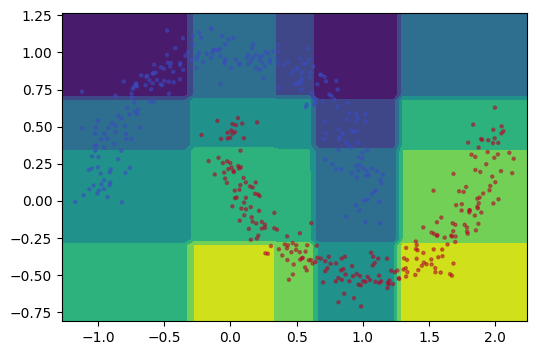

In [24]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

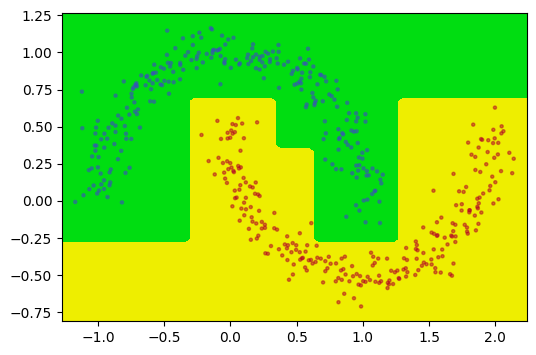

In [25]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict( xy ).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )